# **Import Library**

In [ ]:
from nltk.corpus import stopwords # Daftar kata-kata berhenti dalam teks
from nltk.stem import PorterStemmer # Stemmer yang digunakan adalah Porter Stemmer.
from nltk.tokenize import word_tokenize # Tokenisasi teks
from sklearn.feature_extraction.text import TfidfVectorizer # Konversi teks menjadi vektor TF-IDF
from sklearn.linear_model import LogisticRegression # Algoritma Logistic Regression untuk klasifikasi
from sklearn.metrics import accuracy_score # Metrik akurasi
from sklearn.model_selection import train_test_split # Membagi data menjadi set pelatihan dan pengujian
from tensorflow.keras.callbacks import EarlyStopping # Menghentikan pelatihan model jika tidak ada peningkatan
from tensorflow.keras.layers import Bidirectional, Dense, LSTM, Embedding, SpatialDropout1D # Layer yang digunakan dalam model
from tensorflow.keras.models import Sequential # Model neural network
from tensorflow.keras.preprocessing.sequence import pad_sequences # Mengisi atau memotong teks menjadi panjang yang sama
from tensorflow.keras.preprocessing.text import Tokenizer # Tokenisasi teks
from textblob import TextBlob # Pustaka untuk pemrosesan bahasa alami
from wordcloud import WordCloud # Membuat visualisasi berbentuk awan kata (word cloud) dari teks
import matplotlib.pyplot as plt # Matplotlib untuk visualisasi data
import nltk # Import pustaka NLTK (Natural Language Toolkit).
import numpy as np # NumPy untuk komputasi numerik
import pandas as pd # Pandas untuk manipulasi dan analisis data
import re # Modul untuk bekerja dengan ekspresi reguler
import seaborn as sns # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
import string # Berisi konstanta string, seperti tanda baca
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stop words) dalam berbagai bahasa.
np.random.seed(0) # Mengatur seed untuk reproduktibilitas
pd.options.mode.chained_assignment = None # Menonaktifkan peringatan chaining

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


# **Loading Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Membaca dataset ulasan aplikasi 8 Ball Pool
app_reviews_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/8 Ball Pool Sentiment Analysis/ulasan_aplikasi_8ballpool.csv')
app_reviews_df = app_reviews_df[['content']]

# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = app_reviews_df.shape

print("Jumlah baris:", jumlah_ulasan)
print("Jumlah kolom:", jumlah_kolom)

Jumlah baris: 94500
Jumlah kolom: 1


In [ ]:
# Menampilkan lima baris pertama dari DataFrame app_reviews_df
app_reviews_df.head()

,content
0,Game is very fun and helps you learn about pla...
1,"Would rate it higher, but the physics in this ..."
2,This game is straight up fixed. Insane English...
3,After playing for years now it's time to updat...
4,"The game is fun and addicting, but also extrem..."


In [ ]:
# Menampilkan informasi tentang DataFrame app_reviews_df
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94500 entries, 0 to 94499
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  94500 non-null  object
dtypes: object(1)
memory usage: 738.4+ KB


In [ ]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN) dari app_reviews_df
clean_df = app_reviews_df.dropna()

In [ ]:
# Menampilkan informasi tentang DataFrame clean_df setelah membersihkan nilai yang hilang (NaN)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94500 entries, 0 to 94499
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  94500 non-null  object
dtypes: object(1)
memory usage: 738.4+ KB


In [ ]:
# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

print("Jumlah baris sebelum menghapus duplikat:", jumlah_ulasan)
print("Jumlah baris setelah menghapus duplikat:", jumlah_ulasan_setelah_hapus_duplikat)

Jumlah baris sebelum menghapus duplikat: 94500
Jumlah baris setelah menghapus duplikat: 93585


## Preprocessing

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('english'))
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    stemmer = PorterStemmer()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in text]

    return stemmed_words

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
%%time
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_casefoldingText'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Stemming teks dan menyimpannya di 'text_stemmingText'
clean_df['text_stemmingText'] = clean_df['text_stopword'].apply(stemmingText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stemmingText'].apply(toSentence)

CPU times: user 1min 2s, sys: 1.57 s, total: 1min 4s
Wall time: 1min 6s


In [ ]:
clean_df.head(5)

,content,text_clean,text_casefoldingText,text_tokenizingText,text_stopword,text_stemmingText,text_akhir
0,Game is very fun and helps you learn about pla...,Game is very fun and helps you learn about pla...,game is very fun and helps you learn about pla...,"[game, is, very, fun, and, helps, you, learn, ...","[game, fun, helps, learn, playing, game, real,...","[game, fun, help, learn, play, game, real, rig...",game fun help learn play game real rig opinion...
1,"Would rate it higher, but the physics in this ...",Would rate it higher but the physics in this g...,would rate it higher but the physics in this g...,"[would, rate, it, higher, but, the, physics, i...","[would, rate, higher, physics, game, inconsist...","[would, rate, higher, physic, game, inconsist,...",would rate higher physic game inconsist exampl...
2,This game is straight up fixed. Insane English...,This game is straight up fixed Insane English ...,this game is straight up fixed insane english ...,"[this, game, is, straight, up, fixed, insane, ...","[game, straight, fixed, insane, english, didnt...","[game, straight, fix, insan, english, didnt, s...",game straight fix insan english didnt set appl...
3,After playing for years now it's time to updat...,After playing for years now its time to update...,after playing for years now its time to update...,"[after, playing, for, years, now, its, time, t...","[playing, years, time, update, review, game, a...","[play, year, time, updat, review, game, addict...",play year time updat review game addict amount...
4,"The game is fun and addicting, but also extrem...",The game is fun and addicting but also extreme...,the game is fun and addicting but also extreme...,"[the, game, is, fun, and, addicting, but, also...","[game, fun, addicting, also, extremely, frustr...","[game, fun, addict, also, extrem, frustrat, am...",game fun addict also extrem frustrat amount sl...


## **Labelling (TextBlob)**

In [ ]:
%%time
clean_df['polarity'] = clean_df['text_akhir'].apply(lambda x: TextBlob(x).sentiment.polarity)
clean_df.head(2)

CPU times: user 19.8 s, sys: 53.2 ms, total: 19.9 s
Wall time: 20.6 s


,content,text_clean,text_casefoldingText,text_tokenizingText,text_stopword,text_stemmingText,text_akhir,polarity
0,Game is very fun and helps you learn about pla...,Game is very fun and helps you learn about pla...,game is very fun and helps you learn about pla...,"[game, is, very, fun, and, helps, you, learn, ...","[game, fun, helps, learn, playing, game, real,...","[game, fun, help, learn, play, game, real, rig...",game fun help learn play game real rig opinion...,0.088889
1,"Would rate it higher, but the physics in this ...",Would rate it higher but the physics in this g...,would rate it higher but the physics in this g...,"[would, rate, it, higher, but, the, physics, i...","[would, rate, higher, physics, game, inconsist...","[would, rate, higher, physic, game, inconsist,...",would rate higher physic game inconsist exampl...,-0.012245


In [ ]:
def polarity_to_label(x):
    if(x >= -1 and x < 0):
        return 'neg'
    if(x == 0):
        return 'neutral'
    if(x > 0 and x <= 1):
        return 'pos'

clean_df['label'] = clean_df['polarity'].apply(polarity_to_label)
clean_df.head(2)

,content,text_clean,text_casefoldingText,text_tokenizingText,text_stopword,text_stemmingText,text_akhir,polarity,label
0,Game is very fun and helps you learn about pla...,Game is very fun and helps you learn about pla...,game is very fun and helps you learn about pla...,"[game, is, very, fun, and, helps, you, learn, ...","[game, fun, helps, learn, playing, game, real,...","[game, fun, help, learn, play, game, real, rig...",game fun help learn play game real rig opinion...,0.088889,pos
1,"Would rate it higher, but the physics in this ...",Would rate it higher but the physics in this g...,would rate it higher but the physics in this g...,"[would, rate, it, higher, but, the, physics, i...","[would, rate, higher, physics, game, inconsist...","[would, rate, higher, physic, game, inconsist,...",would rate higher physic game inconsist exampl...,-0.012245,neg


In [ ]:
clean_df['label'].value_counts()

label
neg        42812
pos        42449
neutral     8324
Name: count, dtype: int64

## **Imbalance Data Handling (Undersampling)**

In [ ]:
clean_df.value_counts('label')

label
neg        42812
pos        42449
neutral     8324
Name: count, dtype: int64

In [ ]:
# Pisahkan DataFrame berdasarkan kategori label
positive_df = clean_df[clean_df['label'] == 'pos'].iloc[:8000]
neutral_df = clean_df[clean_df['label'] == 'neutral'].iloc[:8000]
negative_df = clean_df[clean_df['label'] == 'neg'].iloc[:8000]

print(positive_df.shape)
print(neutral_df.shape)
print(negative_df.shape)

(8000, 9)
(8000, 9)
(8000, 9)


In [ ]:
# Gabungkan kembali DataFrame
balanced_df = pd.concat([positive_df, neutral_df, negative_df])

# Reset index DataFrame
balanced_df = balanced_df.reset_index(drop=True)

# Display the balanced DataFrame
balanced_df.head()

,content,text_clean,text_casefoldingText,text_tokenizingText,text_stopword,text_stemmingText,text_akhir,polarity,label
0,Game is very fun and helps you learn about pla...,Game is very fun and helps you learn about pla...,game is very fun and helps you learn about pla...,"[game, is, very, fun, and, helps, you, learn, ...","[game, fun, helps, learn, playing, game, real,...","[game, fun, help, learn, play, game, real, rig...",game fun help learn play game real rig opinion...,0.088889,pos
1,This game is straight up fixed. Insane English...,This game is straight up fixed Insane English ...,this game is straight up fixed insane english ...,"[this, game, is, straight, up, fixed, insane, ...","[game, straight, fixed, insane, english, didnt...","[game, straight, fix, insan, english, didnt, s...",game straight fix insan english didnt set appl...,0.020000,pos
2,"Once you get above Silver League, it's almost ...",Once you get above Silver League its almost im...,once you get above silver league its almost im...,"[once, you, get, above, silver, league, its, a...","[get, silver, league, almost, impossible, win,...","[get, silver, leagu, almost, imposs, win, game...",get silver leagu almost imposs win game row wi...,0.100000,pos
3,So. Much. Fun! So much more than just pool. Th...,So Much Fun So much more than just pool Theres...,so much fun so much more than just pool theres...,"[so, much, fun, so, much, more, than, just, po...","[much, fun, much, pool, theres, items, collect...","[much, fun, much, pool, there, item, collect, ...",much fun much pool there item collect upgrad l...,0.248485,pos
4,It's pretty good if you consistently pay for p...,Its pretty good if you consistently pay for pa...,its pretty good if you consistently pay for pa...,"[its, pretty, good, if, you, consistently, pay...","[pretty, good, consistently, pay, pass, dont, ...","[pretti, good, consist, pay, pass, dont, good,...",pretti good consist pay pass dont good luck ge...,0.286429,pos


## **Visualization**

### Class Distribution Pie Chart

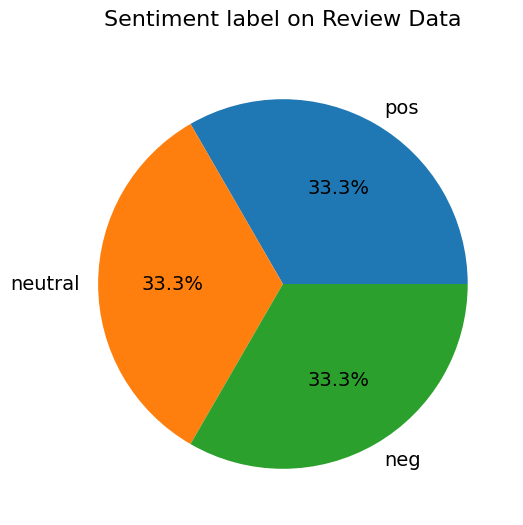

In [ ]:
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'balanced_df' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in balanced_df['label'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'balanced_df' dan menyimpannya dalam list 'labels'.
labels = list(balanced_df['label'].value_counts().index)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Sentiment label on Review Data', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

### Class Distribution Bar Chart

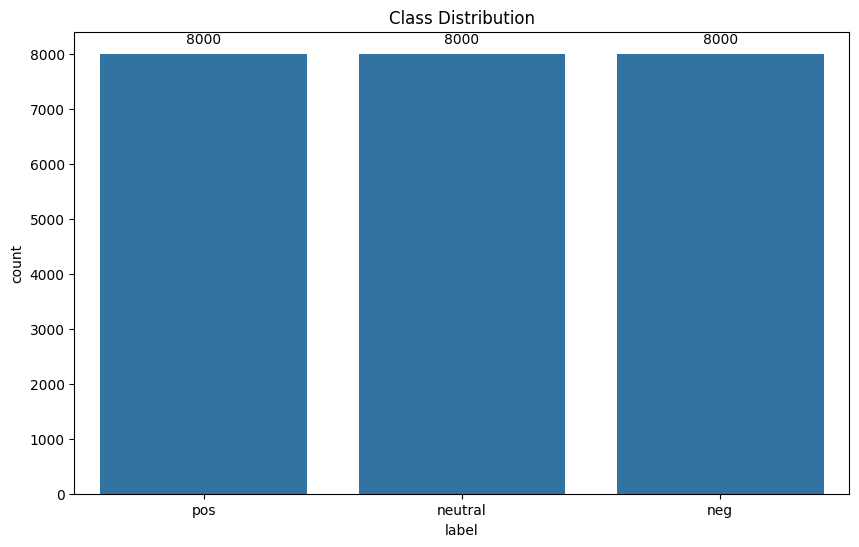

CPU times: user 259 ms, sys: 119 ms, total: 378 ms
Wall time: 254 ms


In [ ]:
%%time
# Set the figure size
plt.figure(figsize=(10, 6))

# Check class distribution
class_dist_plot = sns.countplot(x='label', data=balanced_df)
plt.title('Class Distribution')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points'
    )

plt.show()

### Text Length Distribution

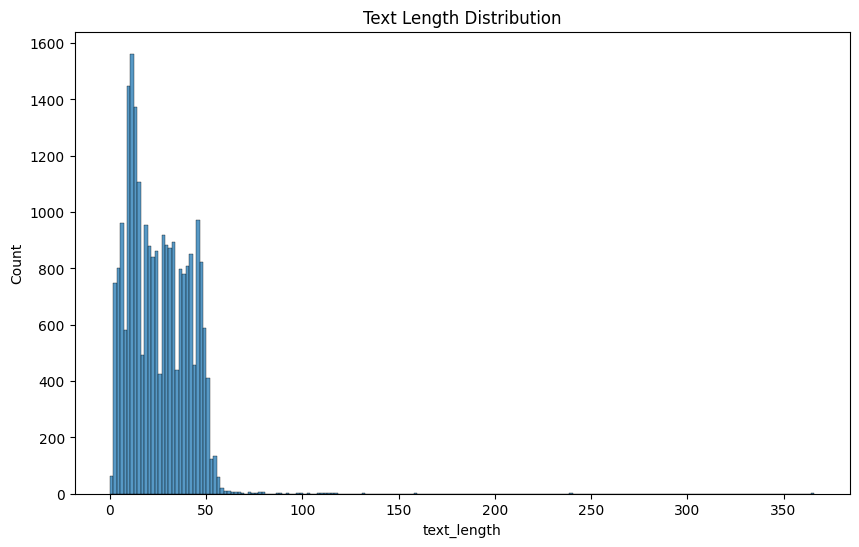

CPU times: user 551 ms, sys: 117 ms, total: 668 ms
Wall time: 535 ms


In [ ]:
%%time
# Set the figure size
plt.figure(figsize=(10, 6))

# Visualize text length distribution
balanced_df['text_length'] = balanced_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(balanced_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

### Most Frequent Words

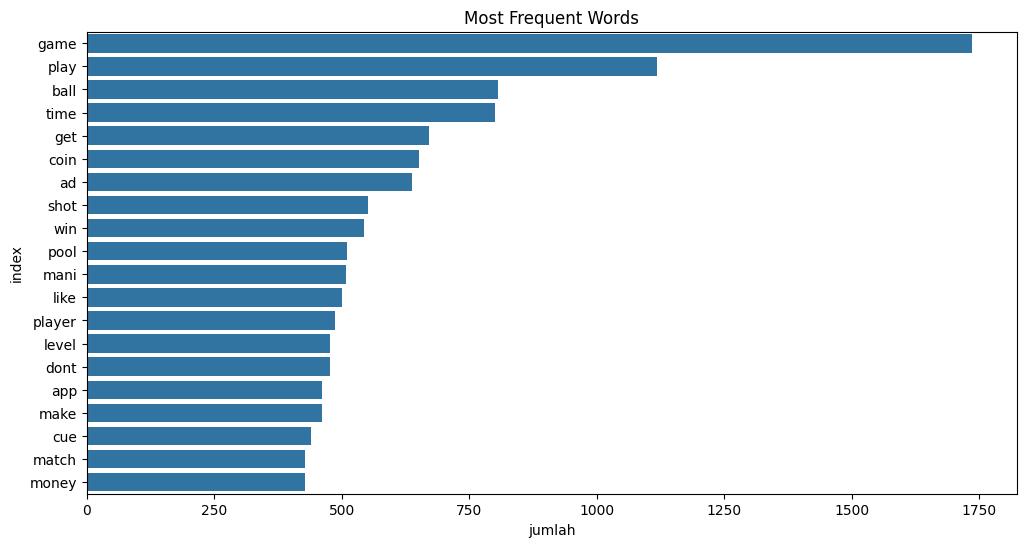

CPU times: user 2.17 s, sys: 1.89 s, total: 4.06 s
Wall time: 4.13 s


In [ ]:
%%time
# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(balanced_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

### Word Cloud of Positive Review Data

In [ ]:
# Membuat DataFrame baru 'positive_reviews' yang hanya berisi review dengan polaritas positif.
positive_reviews = balanced_df[balanced_df['label'] == 'pos']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'positive_reviews'.
positive_reviews = positive_reviews[['text_akhir', 'label','text_stopword']]

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
positive_reviews = positive_reviews.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
positive_reviews.index += 1

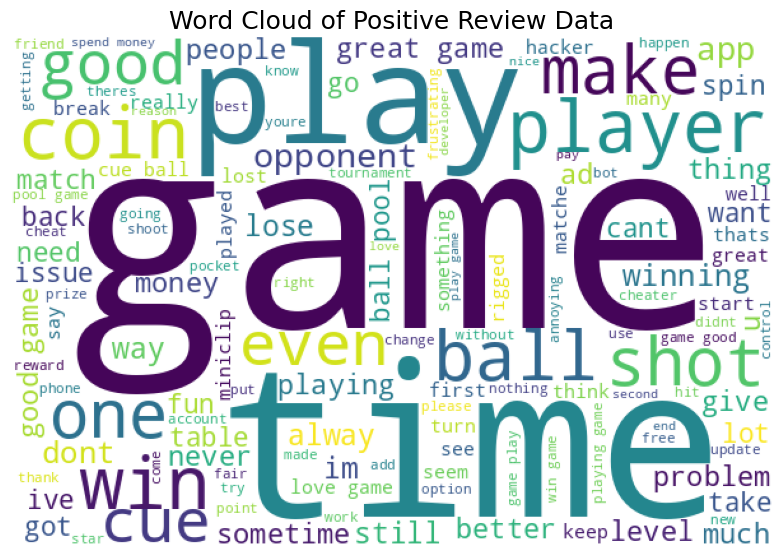

CPU times: user 2.05 s, sys: 274 ms, total: 2.33 s
Wall time: 2.16 s


In [ ]:
%%time
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam review positif.
list_words = ''

# Iterasi melalui setiap review dalam kolom 'text_stopword' dari DataFrame 'positive_reviews'.
for review in positive_reviews['text_stopword']:
    # Iterasi melalui setiap kata dalam review.
    for word in review:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Positive Review Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

### Word Cloud of Neutral Review Data

In [ ]:
# Membuat DataFrame baru 'neutral_reviews' yang hanya berisi review dengan polaritas positif.
neutral_reviews = balanced_df[balanced_df['label'] == 'neutral']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'neutral_reviews'.
neutral_reviews = neutral_reviews[['text_akhir', 'label','text_stopword']]

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
neutral_reviews = neutral_reviews.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
neutral_reviews.index += 1

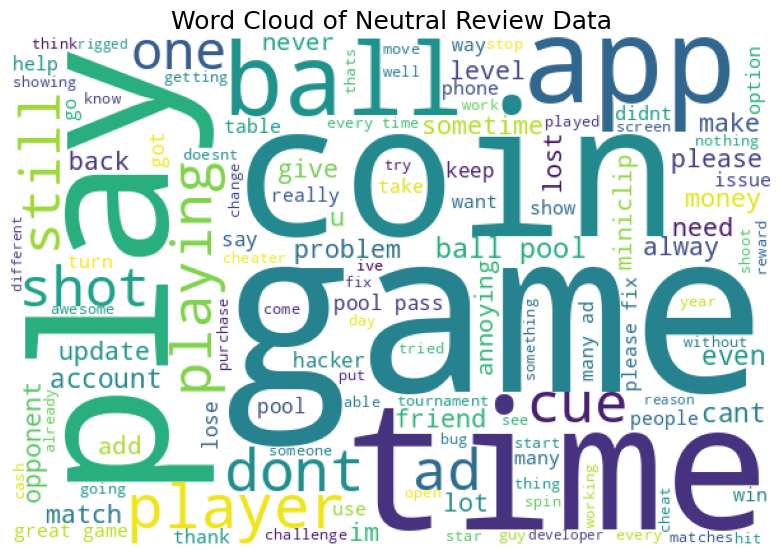

CPU times: user 1.3 s, sys: 208 ms, total: 1.51 s
Wall time: 1.32 s


In [ ]:
%%time
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam review netral.
list_words = ''

# Iterasi melalui setiap review dalam kolom 'text_stopword' dari DataFrame 'neutral_reviews'.
for review in neutral_reviews['text_stopword']:
    # Iterasi melalui setiap kata dalam review.
    for word in review:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Neutral Review Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

### Word Cloud of Negative Review Data

In [ ]:
# Membuat DataFrame baru 'negative_reviews' yang hanya berisi review dengan polaritas negatif.
negative_reviews = balanced_df[balanced_df['label'] == 'neg']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'negative_reviews'.
negative_reviews = negative_reviews[['text_akhir', 'label','text_stopword']]

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
negative_reviews = negative_reviews.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
negative_reviews.index += 1

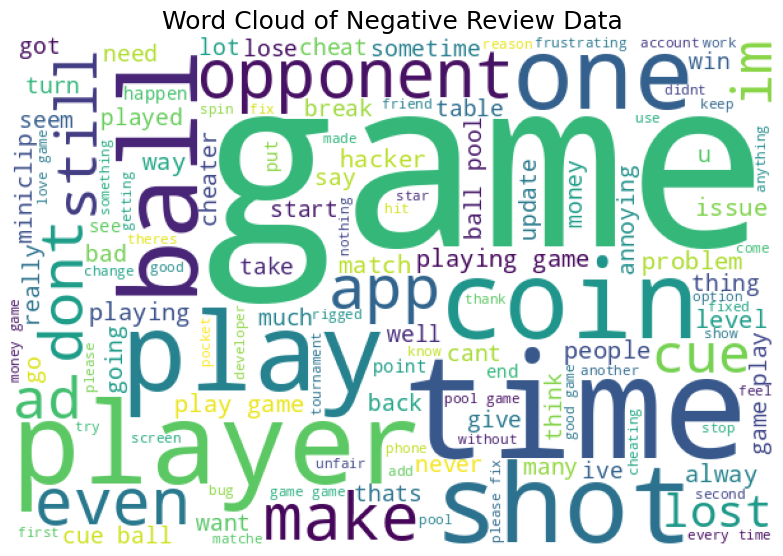

CPU times: user 3.09 s, sys: 261 ms, total: 3.35 s
Wall time: 3.3 s


In [ ]:
%%time
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam review negatif.
list_words = ''

# Iterasi melalui setiap review dalam kolom 'text_stopword' dari DataFrame 'negative_reviews'.
for review in negative_reviews['text_stopword']:
    # Iterasi melalui setiap kata dalam review.
    for word in review:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Negative Review Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

# **Skema 1: Logistic Regression + 9:1 Train-Test Split**

## Feature Extraction (TF-IDF)

In [ ]:
balanced_df.head(1)

,content,text_clean,text_casefoldingText,text_tokenizingText,text_stopword,text_stemmingText,text_akhir,polarity,label,text_length
0,Game is very fun and helps you learn about pla...,Game is very fun and helps you learn about pla...,game is very fun and helps you learn about pla...,"[game, is, very, fun, and, helps, you, learn, ...","[game, fun, helps, learn, playing, game, real,...","[game, fun, help, learn, play, game, real, rig...",game fun help learn play game real rig opinion...,0.088889,pos,42


In [ ]:
# Pisahkan data menjadi fitur dan label (sentimen)
X = balanced_df['text_akhir']
y = balanced_df['label']

In [ ]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

In [ ]:
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,aa,aaa,aaaaa,aaaaaaaand,aaaaaargh,aaaaand,aaaahaaaa,aaaand,aaaargh,aaand,...,𝚜𝚞𝚙𝚎𝚛𝚌𝚘𝚗𝚎𝚌𝚝𝚎𝚍,𝚝𝚑𝚊𝚝𝚜,𝚝𝚑𝚎,𝚝𝚑𝚒𝚜,𝚝𝚘,𝚠𝚊𝚜,𝚠𝚑𝚒𝚕𝚎,𝚠𝚒𝚕𝚕,𝚢𝚘𝚞,𝚢𝚘𝚞𝚛
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Splitting (9:1)

In [ ]:
# Bagi data menjadi data latih dan data uji (90% data latih, 10% data uji)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.1, random_state=42)

# Menampilkan dimensi data latih dan data uji
print("Dimensi data latih:", X_train.shape, y_train.shape)
print("Dimensi data uji:", X_test.shape, y_test.shape)

Dimensi data latih: (21600, 16407) (21600,)
Dimensi data uji: (2400, 16407) (2400,)


## Model Training

In [ ]:
%%time
# Membuat objek model Logistic Regression
lr_model = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
lr_model.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = lr_model.predict(X_train.toarray())
y_pred_test_lr = lr_model.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - accuracy_train: 0.9407407407407408
Logistic Regression - accuracy_test: 0.89375
CPU times: user 3min 3s, sys: 18.1 s, total: 3min 21s
Wall time: 2min 4s


## Review Prediction

In [ ]:
def review_predict(text):
  # Melakukan preprocessing pada kalimat baru
  kalimat_baru_cleaned = cleaningText(text)
  kalimat_baru_casefolded = casefoldingText(kalimat_baru_cleaned)
  kalimat_baru_tokenized = tokenizingText(kalimat_baru_casefolded)
  kalimat_baru_filtered = filteringText(kalimat_baru_tokenized)
  kalimat_baru_stemmed = stemmingText(kalimat_baru_filtered)
  kalimat_baru_final = toSentence(kalimat_baru_stemmed)

  # Menggunakan objek tfidf yang sudah di-fit dari pelatihan sebelumnya
  X_kalimat_baru = tfidf.transform([kalimat_baru_final])

  # Memperoleh prediksi sentimen kalimat baru
  prediksi_sentimen_logistic_regression = lr_model.predict(X_kalimat_baru)

  # Menampilkan hasil prediksi
  if prediksi_sentimen_logistic_regression == 'pos':
    print('Logistic Regression: Kalimat positif')
  elif prediksi_sentimen_logistic_regression == 'neg':
    print('Logistic Regression: Kalimat negatif')
  else:
    print('Logistic Regression: Kalimat neutral')

In [ ]:
kalimat_baru = '''One of the worst games I have ever played. It's like it's not even trying to hide the fact you play against AI. How I know this is that they always go for solids, never stripes, and when aiming have quick and spontaneous movements. Even when stripes has an easier ball to hit they still go for solids and 9 times out of 10 they don't have a profile picture. Another thing is after doing a spin in puts up the premium spin, I don't want or care about the premium spin so stop bringing it up.'''
review_predict(kalimat_baru)

Logistic Regression: Kalimat negatif


# **Skema 2: LSTM + 8:2 Train-Test Split**

In [ ]:
MAX_NB_WORDS = 50000 # Jumlah kata yang akan digunakan
MAX_SEQUENCE_LENGTH = 250 # Panjang maksimum dari setiap kalimat
EMBEDDING_DIM = 100 # Dimensi vektor embedding

## Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(balanced_df['text_akhir'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16446 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(balanced_df['text_akhir'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (24000, 250)


In [ ]:
Y = pd.get_dummies(balanced_df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (24000, 3)


## Data Splitting (8:2)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(19200, 250) (19200, 3)
(4800, 250) (4800, 3)


## Model Training

In [ ]:
# Define the LSTM model architecture
lstm_model = Sequential()
lstm_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
epochs = 5
batch_size = 64
history = lstm_model.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

Epoch 1/5
270/270 [==============================] - 156s 560ms/step - loss: 0.6635 - accuracy: 0.6860 - val_loss: 0.4442 - val_accuracy: 0.8198
Epoch 2/5
270/270 [==============================] - 133s 493ms/step - loss: 0.2811 - accuracy: 0.8961 - val_loss: 0.3136 - val_accuracy: 0.8839
Epoch 3/5
270/270 [==============================] - 130s 481ms/step - loss: 0.1632 - accuracy: 0.9419 - val_loss: 0.2822 - val_accuracy: 0.8958
Epoch 4/5
270/270 [==============================] - 130s 481ms/step - loss: 0.1154 - accuracy: 0.9617 - val_loss: 0.2624 - val_accuracy: 0.9068
Epoch 5/5
270/270 [==============================] - 130s 482ms/step - loss: 0.0927 - accuracy: 0.9700 - val_loss: 0.3105 - val_accuracy: 0.9068


In [ ]:
accuracy_train_lstm = lstm_model.evaluate(X_train, Y_train)
print('LSTM - accuracy_train:', accuracy_train_lstm[1])

600/600 [==============================] - 46s 76ms/step - loss: 0.0845 - accuracy: 0.9739
LSTM - accuracy_train: 0.9738541841506958


In [ ]:
accuracy_test_lstm = lstm_model.evaluate(X_test, Y_test)
print('LSTM - accuracy_test:', accuracy_test_lstm[1])

150/150 [==============================] - 11s 73ms/step - loss: 0.2543 - accuracy: 0.9173
LSTM - accuracy_test: 0.9172916412353516


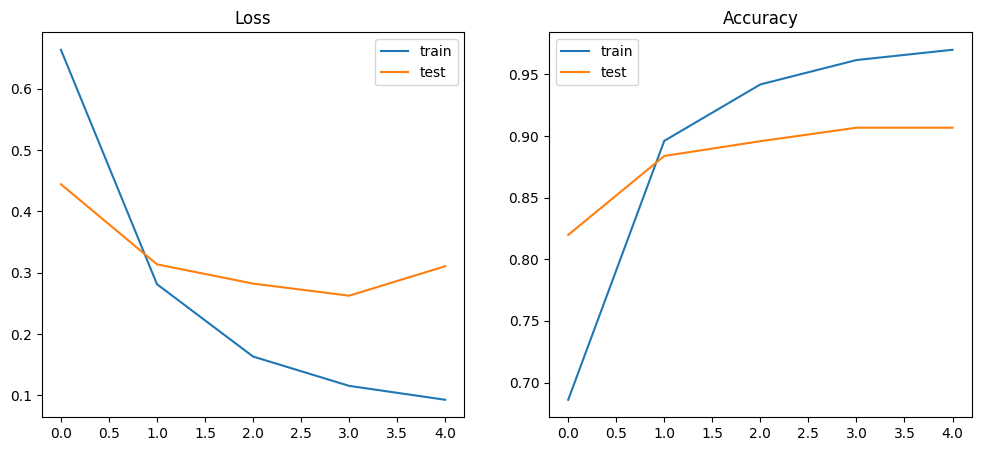

In [ ]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss on the first subplot
ax1.set_title('Loss')
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='test')
ax1.legend()

# Plot Accuracy on the second subplot
ax2.set_title('Accuracy')
ax2.plot(history.history['accuracy'], label='train')
ax2.plot(history.history['val_accuracy'], label='test')
ax2.legend()

# Display the plots
plt.show()

## Review Prediction

In [ ]:
new_review = ['''Very upsetting, I had a few million coins when the dang game started glitching, I would make a shot and the game would glitch and you could clearly see that the shot went in but the screen would flàsh and the balls would be right back like they were before I shot. And the opponent would have ball in hand. Then for some ungodly reason the game restarted and almost all of my coins were gone!!!!! There should be some way to get them back since it was the game that took them. About ready to delete!!''']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = lstm_model.predict(padded)
labels = ['neg', 'neutral', 'pos']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 349ms/step
[[9.9996173e-01 1.7572036e-05 2.0767768e-05]] neg


# **Skema 3: Bi-LSTM + 7:3 Train-Test Split**

## Data Splitting (7:3)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(16800, 250) (16800, 3)
(7200, 250) (7200, 3)


## Model Training

In [ ]:
# Define the Bi-LSTM model architecture
bilstm_model = Sequential()
bilstm_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
bilstm_model.add(SpatialDropout1D(0.2))
bilstm_model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
bilstm_model.add(Dense(3, activation='softmax'))
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
epochs = 5
batch_size = 64
history = bilstm_model.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

Epoch 1/5
237/237 [==============================] - 406s 2s/step - loss: 0.7013 - accuracy: 0.6670 - val_loss: 0.4166 - val_accuracy: 0.8411
Epoch 2/5
237/237 [==============================] - 392s 2s/step - loss: 0.3068 - accuracy: 0.8829 - val_loss: 0.3371 - val_accuracy: 0.8738
Epoch 3/5
237/237 [==============================] - 390s 2s/step - loss: 0.1814 - accuracy: 0.9344 - val_loss: 0.3168 - val_accuracy: 0.8857
Epoch 4/5
237/237 [==============================] - 393s 2s/step - loss: 0.1239 - accuracy: 0.9562 - val_loss: 0.3140 - val_accuracy: 0.8851
Epoch 5/5
237/237 [==============================] - 387s 2s/step - loss: 0.0931 - accuracy: 0.9686 - val_loss: 0.2979 - val_accuracy: 0.9071


In [ ]:
accuracy_train_bilstm = bilstm_model.evaluate(X_train, Y_train)
print('Bi-LSTM - accuracy_train:', accuracy_train_bilstm[1])

525/525 [==============================] - 75s 142ms/step - loss: 0.0742 - accuracy: 0.9776
Bi-LSTM - accuracy_train: 0.977559506893158


In [ ]:
accuracy_test_bilstm = bilstm_model.evaluate(X_test, Y_test)
print('Bi-LSTM - accuracy_test:', accuracy_test_bilstm[1])

225/225 [==============================] - 47s 208ms/step - loss: 0.2599 - accuracy: 0.9197
Bi-LSTM - accuracy_test: 0.9197221994400024


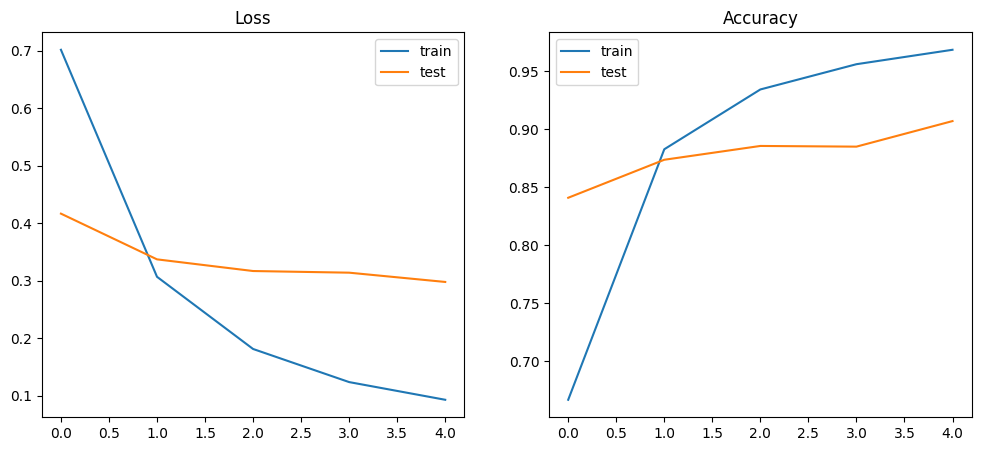

In [ ]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss on the first subplot
ax1.set_title('Loss')
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='test')
ax1.legend()

# Plot Accuracy on the second subplot
ax2.set_title('Accuracy')
ax2.plot(history.history['accuracy'], label='train')
ax2.plot(history.history['val_accuracy'], label='test')
ax2.legend()

# Display the plots
plt.show()

## Review Prediction

In [ ]:
new_review = ['''Very upsetting, I had a few million coins when the dang game started glitching, I would make a shot and the game would glitch and you could clearly see that the shot went in but the screen would flàsh and the balls would be right back like they were before I shot. And the opponent would have ball in hand. Then for some ungodly reason the game restarted and almost all of my coins were gone!!!!! There should be some way to get them back since it was the game that took them. About ready to delete!!''']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = bilstm_model.predict(padded)
labels = ['neg', 'neutral', 'pos']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 129ms/step
[[9.9995363e-01 3.8384027e-05 7.9812744e-06]] neg


# **Accuracy Comparison**

In [ ]:
# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    'Model': ['Skema 1 (LR + 90-10)', 'Skema 2 (LSTM + 80-20)', 'Skema 3 (Bi-LSTM + 70-30)'],
    'Accuracy Train': [accuracy_train_lr, accuracy_train_lstm[1], accuracy_train_bilstm[1]],
    'Accuracy Test': [accuracy_test_lr, accuracy_test_lstm[1], accuracy_test_bilstm[1]]
})

# Menampilkan hanya kolom "Accuracy Test"
accuracy_test_only = results_df[['Model', 'Accuracy Test']]
# Mengurutkan DataFrame berdasarkan kolom "Accuracy Test" dari tertinggi ke terendah
accuracy_test_only = accuracy_test_only.sort_values(by='Accuracy Test', ascending=False)
print(accuracy_test_only)

                       Model  Accuracy Test
2  Skema 3 (Bi-LSTM + 70-30)       0.919722
1     Skema 2 (LSTM + 80-20)       0.917292
0       Skema 1 (LR + 90-10)       0.893750
